In [1]:
%load_ext autoreload
%autoreload 2

from evaluation_scripts.base import load_json, load_toml, get_base_pathes
import pandas as pd
import os
from evaluation_scripts.base import load_pickle_obj
from model_scripts.sensitivity_evaluation import SensitivityAnalysis
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns


_, base = get_base_pathes()
path = os.path.join(base, "sensitivity_sim")

In [2]:
sensitivity = SensitivityAnalysis(path, parameter_names = ["turnover",
                                "infection", "cA", "cB", "cS", "cU", "cAB"])
reload = True
if reload:
    sensitivity.load()
else:
    sims = load_pickle_obj(os.path.join(path, "sensitivity_sim_ab.pkl"))
    pars = load_pickle_obj(os.path.join(path, "sensitivity_par_ab.pkl"))
    sensitivity.evaluate_parameter_sets(sims, pars)
    sensitivity.save()

In [3]:
for evaluation in sensitivity.evaluations:
    pass
evaluation.worst_strategies

['Mono B']

In [4]:
shared_winners = []
single_winners = []
single_loser = []
shared_loser = []

for evaluation in sensitivity.evaluations:
    if evaluation.best_strategy == "None":
        shared_winners += ["All"]
    else:
        if len(evaluation.best_strategies) == 1:
            single_winners += evaluation.best_strategies
        else:
            shared_winners += evaluation.best_strategies
        if len(evaluation.worst_strategies) == 1:
            single_loser += evaluation.worst_strategies
        else:
            shared_loser += evaluation.worst_strategies
entry_counts = Counter(shared_winners)
entry_counts_single = Counter(single_winners)
single_loser_counts = Counter(single_loser)
shared_loser_counts = Counter(shared_loser)



In [5]:
df_single

NameError: name 'df_single' is not defined

In [77]:
df = pd.DataFrame()
df["strategy"] = entry_counts.keys()
df["multiple_winners_count"] = entry_counts.values()
df.replace("Combo", "Combination", inplace=True)

df_single = pd.DataFrame()
df_single["strategy"] = entry_counts_single.keys()
df_single["single_winners_count"] = entry_counts_single.values()
df_single.replace("Combo", "Combination", inplace=True)

df_loser = pd.DataFrame()
df_loser["strategy"] = shared_loser_counts.keys()
df_loser["multiple_losers_count"] = shared_loser_counts.values()
df_loser.replace("Combo", "Combination", inplace=True)

df_single_loser = pd.DataFrame()
df_single_loser["strategy"] = single_loser_counts.keys()
df_single_loser["single_losers_count"] = single_loser_counts.values()
df_single_loser.replace("Combo", "Combination", inplace=True)

combined = df
combined = combined.set_index("strategy")
combined.loc[df_single.set_index("strategy").index, "single_winners_count"] = df_single.set_index("strategy")["single_winners_count"]
combined.loc[df_loser.set_index("strategy").index, "multiple_losers_count"] = df_loser.set_index("strategy")["multiple_losers_count"]
combined.loc[df_single_loser.set_index("strategy").index, "single_losers_count"] = df_single_loser.set_index("strategy")["single_losers_count"]

combined = combined.fillna(0)
order = ["Combination", "Cycling", "Mixing", "Mono A", "Mono B"]
combined = combined.loc[order]

combined

,multiple_winners_count,single_winners_count,multiple_losers_count,single_losers_count
strategy,,,,
Combination,1534,8206.0,9.0,0.0
Cycling,1146,12.0,943.0,0.0
Mixing,691,5.0,1269.0,1.0
Mono A,334,72.0,2386.0,3111.0
Mono B,351,0.0,1815.0,4324.0


In [ ]:
color_1 = ["#FFA500", "#FF8C00", "#FF6347"]
color_2 = ["#00CED1", "#40E0D0", "#20B2AA"]

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import matplotlib.patches as patches


center_positions = combined.index
width = 0.75
fontsize = 14
axes_label_fontsize = 16

def barplot_wins(df, ax=plt, bar_width=1):
    df = df[["single_winners_count", "multiple_winners_count"]].copy()
    df.loc["All"] = 0
    df.rename(index={"All": "No winner"}, inplace=True)
    df.plot(kind='bar', stacked=True, color=[color_2[2], color_2[1]], ax=ax, width=bar_width, label=["Single Winners", "Multiple Winners"])

def barplot_losses(df, ax=plt, bar_width=1):
    df = -df[["single_losers_count", "multiple_losers_count"]].copy()
    df.loc["All"] = 0
    df.rename(index={"All": "Insignificant"}, inplace=True)
    df.plot(kind='bar', stacked=True, color=[color_1[1], color_1[0]], ax=ax, width=bar_width, label=["Single Losers", "Multiple Losers"])

def add_bar(index_value, count_value, color, ax=plt, legend_label="p>0.05", bar_width=1):
    ax.bar(index_value, count_value, color=color, label=legend_label, width=bar_width)

plt.figure(figsize=(16, 8))
ax = plt.gca()

# Plot wins
barplot_wins(combined, ax=ax, bar_width=width)

# Plot losses
barplot_losses(combined, ax=ax, bar_width=width)
add_bar(5, 130, color="black", ax=ax, bar_width=width)

# Update legend with combined labels
ax.legend(fontsize=fontsize, labels=["Single Winner", "Shared Win", "Single Loser", "Shared Loss", "Insignificant"])


# Remove negative signs from y-axis tick labels
ax.set_yticklabels([abs(int(label)) for label in ax.get_yticks()])




# Remove box around the plot
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# Create custom axes using patches
ax.axhline(y=0, color='grey', linewidth=2, alpha = 0.5, xmin=0.01, xmax=0.99)  

ax.add_patch(patches.FancyArrowPatch((-.6, -10), (-.6, 10500), arrowstyle='->', color='black', mutation_scale=15))
ax.add_patch(patches.FancyArrowPatch((-.6, 1), (-.6, -6550), arrowstyle='->', color='black', mutation_scale=15))
ax.annotate('Wins', xy=(-.6, 10000), xytext=(10, 0), textcoords='offset points', fontsize = axes_label_fontsize)
ax.annotate('Losses', xy=(-.6, -6500), xytext=(10, 0), textcoords='offset points', fontsize = axes_label_fontsize)

ax.tick_params(axis='y', labelsize=fontsize, rotation=0)
ax.tick_params(axis='x', labelsize=fontsize, rotation=0)
ax.set_xlabel("")
ax.set_ylabel("Counts", fontsize=axes_label_fontsize)

plt.tight_layout()

plt.savefig(os.path.join(path, "wins_and_losses.pdf"))
plt.show()


In [ ]:
combined

In [ ]:
combined["total wins"] = combined.multiple_winners_count + combined.single_winners_count
combined["total wins in %"] = combined["total wins"]/10000
combined["total losses"] = combined.single_losers_count + combined.multiple_losers_count
combined["total losses in %"] = combined["total losses"]/10000
combined


In [40]:
def eval_scenario(evaluation):
    losing =[]
    winning = []
    if evaluation.best_strategy != "None": 
        community = evaluation.parameter_set["community"]
        c = {"cA":community["A_r"], "cB":community["B_r"]}
        for l in evaluation.worst_strategies:
            row = c.copy()
            row.update({"losing_strategy" : l, "single_loser" : len(evaluation.worst_strategies) == 1})
            losing.append(row)
        for w in evaluation.best_strategies:
            row = c.copy()
            row.update({"winning_strategy" : w, "single_winner" : len(evaluation.best_strategies) == 1})
            winning.append(row)
    return losing, winning

losing, winning = eval_scenario(evaluation)

In [54]:
losing =[]
winning = []
for evaluation in sensitivity.evaluations:
    l, w = eval_scenario(evaluation)
    losing += l
    winning += w
df_L = pd.DataFrame(losing)
df_W = pd.DataFrame(winning)

In [67]:
df_L["symmetrie"] = df_L.cA - df_L.cB / (df_L.cA + df_L.cB)
df_W["symmetrie"] = df_W.cA - df_W.cB / (df_W.cA + df_W.cB)
df_W

,cA,cB,winning_strategy,single_winner,symmetrie
0,0.08,0.30,Combo,True,-0.709474
1,0.13,0.16,Combo,True,-0.421724
2,0.44,0.06,Combo,False,0.320000
3,0.44,0.06,Mono B,False,0.320000
4,0.13,0.26,Combo,True,-0.536667
...,...,...,...,...,...
12346,0.32,0.08,Combo,True,0.120000
12347,0.00,0.45,Combo,False,-1.000000
12348,0.00,0.45,Mono A,False,-1.000000
12349,0.25,0.43,Combo,True,-0.382353


<AxesSubplot: xlabel='losing_strategy', ylabel='symmetrie'>

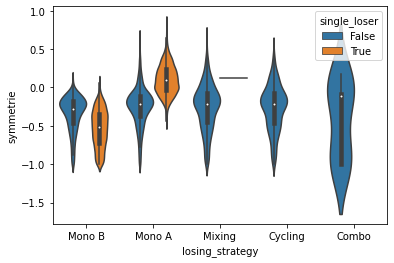

In [84]:
sns.violinplot(data = df_L, x = "losing_strategy", hue = "single_loser", y = "symmetrie")

<AxesSubplot: xlabel='winning_strategy', ylabel='symmetrie'>

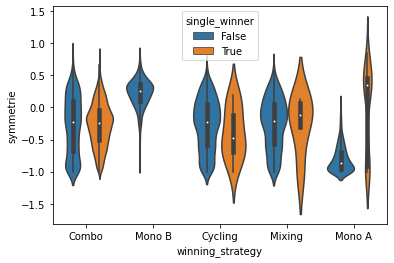

In [83]:
sns.violinplot(data = df_W, x = "winning_strategy", hue = "single_winner", y = "symmetrie")

In [ ]:
shared_winners = []
single_winners = []
single_loser = []
shared_loser = []

for evaluation in sensitivity.evaluations:
    if evaluation.best_strategy == "None":
        shared_winners += ["All"]
    else:
        if len(evaluation.best_strategies) == 1:
            single_winners += evaluation.best_strategies
        else:
            shared_winners += evaluation.best_strategies
        if len(evaluation.worst_strategies) == 1:
            single_loser += evaluation.worst_strategies
        else:
            shared_loser += evaluation.worst_strategies
entry_counts = Counter(shared_winners)
entry_counts_single = Counter(single_winners)
single_loser_counts = Counter(single_loser)
shared_loser_counts = Counter(shared_loser)

